# Non-Adiabatic Particle In A Box

This Notebook is compatible with Jupiter Notebook v6.5.3

## Import Necessary Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter #PillowWriter
from scipy.linalg import eigh
from scipy.io import wavfile # for sound waves
#from IPython.display import Audio # for sound waves

## Define Constants and Parameters

## Plotting Energy Levels

In [2]:
%matplotlib inline

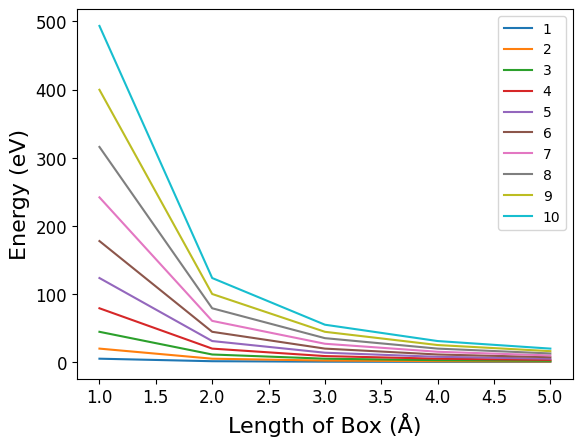

In [3]:
m = 1
pi = math.pi
hbar = 1

def E(n, L):
    return (n**2 * pi**2 * hbar**2) / (2 * m * L**2)

Elist = []

mm = 6
xr = range(1, mm)

for n in range(1, 11):
    Elist = [E(n, l) for l in xr]
    plt.plot(xr, Elist, label=f'n={n}')
    
plt.legend(range(1, 11))
plt.xlabel("Length of Box (Å)", fontsize=16)
plt.ylabel("Energy (eV)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title("Energy values versus box length")
plt.show()

https://people.uncw.edu/hermanr/qm/Finite_Square_Well.pdf

## Predicted Transitions

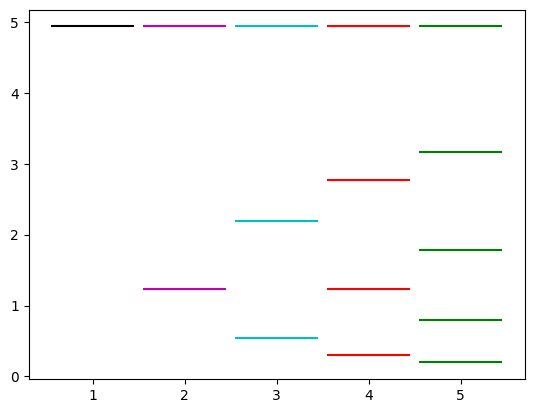

In [4]:
c_list = ["g", "k", "m","c", "r"]

for l in range(1, mm):
    Elist = [E(n, l) for n in range(1, 11)]
    for energies in Elist:
        if energies <= E(1, 1):
            color = c_list[l % len(c_list)]
            plt.hlines(energies, l - 0.45, l + 0.45, colors=color)

In [5]:
# Atomic base units:
bhorradius = 1  # length
hbar = 1  # in atomic units
me = 1  # mass of electron in atomic units
Hartree = 1  # energy

# Convenient units in terms of atomic units:
angs = 1 / 0.529177  # in atomic units
fs = 1 / (1e15 * 2.4188843265864e-17)  # in atomic units
eV = 1 / 27.211386245988  # eV in atomic units (Hartree)

# Define parameters
pi = math.pi

mu = 1 * me
dr = 0.1 * angs
r = np.arange(-25 * angs, 30 * angs, dr)

E0 = 2 * eV
r0L = 40 * angs
r0R = 5 * angs

## Set Type to "Notebook" (allows animations)

In [6]:
%matplotlib notebook

<IPython.core.display.Javascript object>


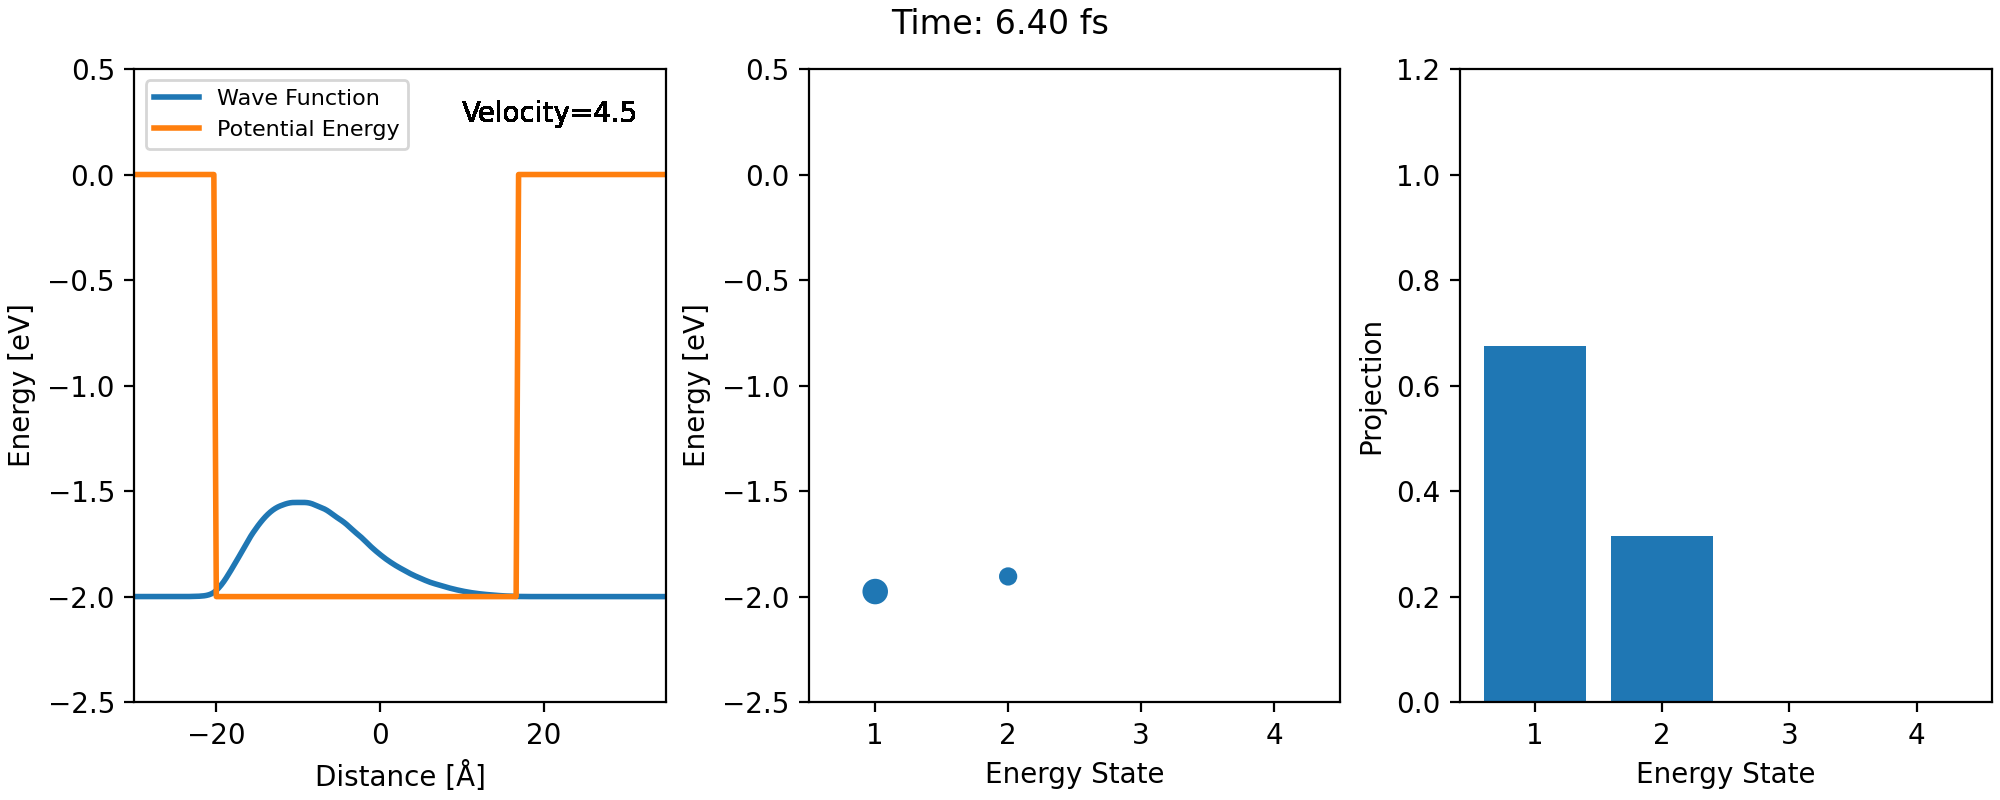

In [12]:
# === Define Box Parameters === #
dr = 0.3 * angs
r = np.arange(-35 * angs, 35 * angs, dr)

well_depth = 2
E0 = well_depth * eV
r0L = 40 * angs
r0R = 5 * angs
mu = 1 * me
# === END === #

# === Define Kinetic Energy and Potential Energy Equations (Do Not Change) === #

# Kinetic energy prefactor
kinEPrefactor = -(1 / (dr ** 2)) * hbar ** 2 / (2 * mu)

# Potential well
PES = -E0 * (1 - np.heaviside(r - r0R / 2, 0.5)) * np.heaviside(r + r0L / 2, 0.5)

# Hamiltonian
H = np.diag(-2 * kinEPrefactor + PES) + np.diag(kinEPrefactor * np.ones(len(r) - 1), 1) + np.diag(kinEPrefactor * np.ones(len(r) - 1), -1)
# === END === #

# === Solve Hamiltonian for Eigenvalues: Energies and Wave Function (Psig) (Do Not Change) === #
# Solve Hamiltonian for eigenvals
Energies, wavefuncs = eigh(H)
Eg = np.diag(Energies)
Psig = wavefuncs[:, 0]
# === END === #

# === Define Expanding Box === #
# Expanding Box
dt = 0.01 * fs

# For fast expansion, coeff = 4.5, for slow expansion, coeff = 0.5
speed_coeff = 4.5
velocity = speed_coeff * angs / fs

expansiondistance = 20 * angs
tfinal = (2 * expansiondistance) / velocity
#t = np.arange(0, tfinal + 100 * fs, dt)
t = np.arange(0, tfinal + 5 * fs, dt) # maybe change so this counts up by 10s?
# === END === #

Psi = Psig.copy()


# === Initialize plot (Do Not Change) === #
fig, ax = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
ax[0].set_xlim(r[0] / angs + 5, r[-1] / angs)
ax[0].set_ylim(-well_depth-0.5, 0.5)
wave_plot, = ax[0].plot([], [], lw=2, label="Wave Function")
pes_plot, = ax[0].plot([], [], lw=2, label="Potential Energy")


ax[0].set(ylabel="Energy [eV]", xlabel="Distance [Å]")
ax[2].set(ylabel="Projection", xlabel="Energy State")
ax[1].set(ylabel="Energy [eV]", xlabel="Energy State")

ax[0].legend(loc="upper left", fontsize=8)


bar_positions = np.arange(1, 5)
start_vals = np.zeros_like(bar_positions)
bars = ax[2].bar(bar_positions, start_vals, label="Projections")
ax[2].set_xticks([1, 2, 3, 4])
ax[2].set_ylim([0, 1.2])

energies = ax[1].scatter([], [], s=20, label="Energies")
ax[1].set_xlim([0.5, 4.5])
ax[1].set_ylim([-well_depth-0.5, 0.5])

def init():
    wave_plot.set_data([], [])
    pes_plot.set_data([], [])
    for bar, val in zip(bars, start_vals):  
        bar.set_height(start_vals)
    energies.set_offsets(np.empty((0, 2))) 
    return wave_plot, pes_plot, bars, energies
# === END === #

PES = -E0

# === Define Plot Updating Using Runge-Kutta 4th Order For Wave Function === #
def update_plot(j):
    global Psi, PES
    if t[j] < tfinal:
        PES = -E0 * (1 - np.heaviside(r - (r0R + velocity * t[j]) / 2, 0.5)) * np.heaviside(r + r0L / 2, 0.5)
    H = np.diag(-2 * kinEPrefactor + PES) + np.diag(kinEPrefactor * np.ones(len(r) - 1), 1) + np.diag(kinEPrefactor * np.ones(len(r) - 1), -1)

    # Runge-Kutta 4th order
    k1 = (-1j / hbar) * H @ Psi #Euler
    k2 = (-1j / hbar) * H @ (Psi + (dt / 2) * k1) #Trapezoidal Rule/ Heun's Method (Predictor-Corrector Method)
    k3 = (-1j / hbar) * H @ (Psi + (dt / 2) * k2)
    k4 = (-1j / hbar) * H @ (Psi + dt * k3)

    Psi = Psi + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    ax[0].text(10, 0.25, f"Velocity={speed_coeff}")

    if j % 10 == 0:
        # Update plots
        functoplot = 25 * (np.abs(Psi) ** 2) + Eg[0] / eV - well_depth
        wave_plot.set_data(r / angs, functoplot)
        pes_plot.set_data(r / angs, PES / eV)

        current_t = t[j]  / fs
        fig.suptitle(f"Time: {current_t:.2f} fs")
        
        Eigenvals, Eigenfuncs = np.linalg.eigh(H)
        Energies = Eigenvals / eV
    
        projections = np.zeros(5)
        
        tottime = 0.1 #0.8   
        samfreq = 40_000 
        tsound = np.linspace(0, tottime, int(samfreq * tottime))
        eVtoSound = 280_000  
        soundfunction = np.zeros(len(tsound))

        offsets = []
        sizes = []
        sound_list = []
        
        for k in range(len(projections)):
            projections[k] = np.abs(np.sum(Psi * Eigenfuncs[:, k]))**2
            
            # Generate Sound
            soundv = 800 + (Energies[k] + 0.1447) * eVtoSound
            soundv = np.abs(soundv)
            if projections[k] < 0.02:
                projections[k] = 0

            soundfunction += projections[k] * np.cos(2 * np.pi * soundv * tsound)
            
            # Determine Sizes of Points In Second Plot
            offsets.append([k + 1, Energies[k]])
            size = int(projections[k]*100)
            sizes.append(size)

        # Set Bar Heights In Third Plot
        for bar, height in zip(bars, projections):
            bar.set_height(height)
        
        # Second Plot Generate Points
        energies.set_sizes(sizes)
        offsets = np.array(offsets)
        energies.set_offsets(offsets)
        
        # Generate Sound Function
        soundfunction = soundfunction / np.max(soundfunction)
        sound_list.append(soundfunction)
        sound_arr = np.array(sound_list).astype(np.float32)

        # Save sound to .wav file for each 10 timesteps
        for i in range(0, len(sound_arr)):
            sound_arr[i] = sound_arr[i] / np.max(sound_arr)
            wavfile.write(f'output_eigh{j}_0_1.wav', samfreq, sound_arr[i].astype(np.float32)) 
            
    return wave_plot, pes_plot, bars, energies
# === END === #

# === Run The Simulation === #
ani = FuncAnimation(fig, update_plot, init_func=init, frames=len(t), interval=2, blit=True, repeat=False)
plt.show()
# === END === #

# === Save The Animation (Will Not Plot To Notebook If Uncommented) === #
#filename = "3plots"
#ani.save(f"{filename}.mp4", writer=FFMpegWriter(fps=60))
# === END === #